# **<center>Practical Implementation </center>**


## <center> Programming Session 4.1 - The Transformer Architecture - </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://hm-ai.github.io/ml-enpc/">
    <img src="https://drive.google.com/uc?export=view&id=12t-JTO4co2ZDxqdmNOOZG104izf5bSye" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/118vVXtZpS3PMmoIBWRErCXCRyNGzRJ7s?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>

In [ ]:
## Import Modules
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization
from tqdm import tqdm_notebook as tqdm

# Scaled Dot Product Attention

### Creating a contextual embedding with Self Attention

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1Wr7AWNqXG9JWgTGJH8TrKM_2DvupWvBU"></center>

Let us consider a sequence of $D$-dimensional input vectors $(X^t)_{1 \leq t \leq T}$. In order to use the attention mechanism, we define the projections of the embeddings $X^t$ onto the $d_q$-dimensional query space, $d_k$-dimensional key space and $d_v$-dimensional value space:


\begin{align*}
     q^t &= W_Q^T X^t \in  \mathbb{R}^{d_q}  \\
    k^t &= W_K^T X^t \in  \mathbb{R}^{d_k}\\
    v^t &= W_V^T X^t \in \mathbb{R}^{d_v} \\
\end{align*}

Where $W_Q \in \mathbb{R}^{D \times d_q}$, $W_K \in \mathbb{R}^{D \times d_k}$ and $W_V \in \mathbb{R}^{D \times d_v}$ are the projection matrices onto the low dimensional query, key and value spaces, respectively. We also need $d_q = d_k$.



Let us consider a query $q^t \in \{q^1, \dots, q^{T}\}$. The Self Attention transformation, represented in figure \ref{fig:Self_Attention} consists in creating a contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ associated with the embedding vector $X^t$.



To that end, the scaled dot product alignment function \cite{vaswani2017attention} is used to calculate the similarity $e^{<t, t'>}$ between the query $q^t$ and the keys $(k^{t'})_{1 \leq t' \leq T}$ as follows:

\begin{equation}
    e^{<t, t'>} = \frac{q^{t}.k^{t'}}{\sqrt{d_k}}
\end{equation}

A Softmax distribution function is then used to turn the similarity scores $e^{<t, t'>}$ into attention weights $\alpha^{<t, t'>}$ representing the contribution of the embedding $X^{t'}$ in the process of generating the contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$.

\begin{equation}
    \alpha^{<t, t'>} = \frac{e^{<t, t'>}}{\sum\limits_{s=1}^T e^{<t, s>}}
\end{equation}

The contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ can then be computed as follows:

\begin{equation}
    A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) = \sum\limits_{t'=1}^T \alpha^{<t, t'>} v^{t'}
\end{equation}





### The Matrix of contextual embeddings

We can generalize the way to create the contextual embedding $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ associated with the embedding $X^t$ to all the embedding vectors $(X^{t'})_{1 \leq t' \leq T}$.


We consider the following matrix notations:


\begin{equation*}
Q =    
\begin{bmatrix}
    \text{---} & q^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & q^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d_q}, \quad
K =    
\begin{bmatrix}
    \text{---} & k^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & k^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d_k}, \quad
V =    
\begin{bmatrix}
    \text{---} & v^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & v^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d_v}
\end{equation*}


We define the scaled dot product attention matrix, denoted $A(Q, K, V)$, as follows:

\begin{equation*}
    A(Q, K, V) := \text{Softmax}\left(\frac{Q K^T}{\sqrt{d_k}} \right) V
\end{equation*}

Where the notation $\text{Softmax}(M)$ for a matrix $ M \in \mathbb{R}^{T \times d}$ refers to the Softmax applied to each row of the matrix $M$.

We have:


\begin{equation*}
    A(Q, K, V) = \begin{bmatrix}
    \text{---} & A\left(q^1, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^T, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right) & \text{---} \\
    \end{bmatrix}
\end{equation*}


In other words, the $t$-th row of the scaled dot product attention matrix $A(Q, K, V)$ is the contextual embedding vectors $A\left(q^t, (k^{t'})_{1 \leq t' \leq T}, (v^{t'})_{1 \leq t' \leq T}\right)$ associated with the embedding vector $X^t$.

In [ ]:
# Scaled_dot_product_attention
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """

    pass


### Test the scaled_dot_product_attention function

In [ ]:
# Create random data
batch_size = 32
seq_len = 10
depth_q = 64
depth_k = depth_q
depth_v = 32

q = tf.random.uniform((batch_size, seq_len, depth_q))  # (32, 10, 64)
k = tf.random.uniform((batch_size, seq_len, depth_k))  # (32, 10, 64)
v = tf.random.uniform((batch_size, seq_len, depth_v))  # (32, 10, 32)

# Call the function
output, attention_weights = scaled_dot_product_attention(q, k, v)

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 10, 32)
Attention weights shape: (32, 10, 10)


### Visualize the Attention Weights for the first sample

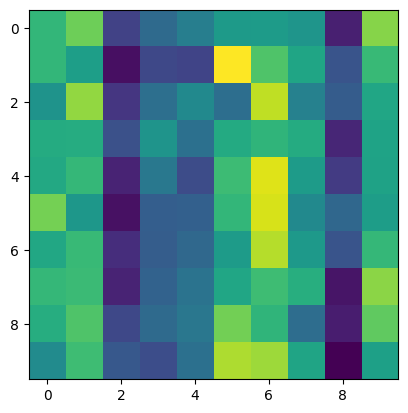

In [ ]:
# Visualize the alignment matrix for the first sample and first head
plt.imshow(attention_weights[0].numpy())

In [ ]:
attention_weights[0].shape

TensorShape([10, 10])

In [ ]:
assert tf.reduce_mean(tf.reduce_sum(attention_weights[0], axis=1)) == 1, "The attention weights don't sum to one"

### Adding a mask

In order to avoid look-ahead bias we introduce the notion of mask. Consider the following queries, keys and values:
    
\begin{equation*}
Q =    
\begin{bmatrix}
    \text{---} & q^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & q^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d}, \quad
K =    
\begin{bmatrix}
    \text{---} & k^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & k^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d}, \quad
V =    
\begin{bmatrix}
    \text{---} & v^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & v^{T} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T \times d}
\end{equation*}


For $t \in \{1, \dots, T \}$, we don't want the contextual embedding associated with the query $q^{t}$ to depend on the pairs $(k_{t'}, v_{t'})_{t \leq t' \leq T}$

Hence, we "mask" the contributions $\alpha^{<t, t'>}$ for all $t' > t$ by setting them to zero.

So, we set $e^{<t, t'>}$ to $- \infty$ for all $t' > t$ as shown in the following table:  


<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1xgvMf5vGaenUVvyLEsnUU4FF68On12ao"></center>


After applying the softmax, we get the masked attention weights:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1JGyr6iVG7B7psxR7MviarVWZDrqhk8ch"></center>

In [ ]:
def create_look_ahead_mask(sequence_length):
    """
    Returns an upper triangular matrix filled with ones

    Arguments:
        sequence_length -- matrix size

    Returns:
        mask -- (1, size, size) tensor
    """
    pass

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

In [ ]:
# Create random data
batch_size = 32
seq_len = 10
depth_q = 64
depth_k = depth_q
depth_v = 32

q = tf.random.uniform((batch_size, seq_len, depth_q))  # (32, 10, 64)
k = tf.random.uniform((batch_size, seq_len, depth_k))  # (32, 10, 64)
v = tf.random.uniform((batch_size, seq_len, depth_v))  # (32, 10, 32)

# Call the function
output, attention_weights = scaled_dot_product_attention(q, k, v, mask=create_look_ahead_mask(seq_len))

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 10, 32)
Attention weights shape: (32, 10, 10)


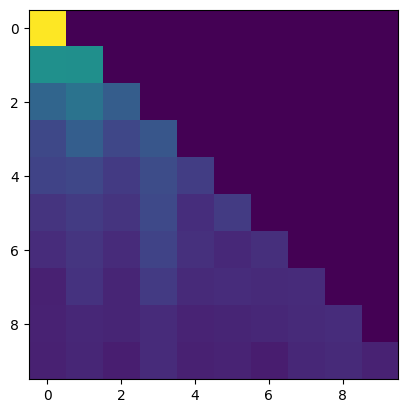

In [ ]:
# Visualize the alignment matrix for the first sample
plt.imshow(attention_weights[0].numpy())

### Applying the Scaled Dot Product Attention several times

In [ ]:
# Create random data
batch_size = 32
num_heads = 8
seq_len = 10
depth_q = 64
depth_k = depth_q
depth_v = 32

q = tf.random.uniform((batch_size, num_heads, seq_len, depth_q))  # (32, 8, 10, 64)
k = tf.random.uniform((batch_size, num_heads, seq_len, depth_k))  # (32, 8, 10, 64)
v = tf.random.uniform((batch_size, num_heads, seq_len, depth_v))  # (32, 8, 10, 32)

# Call the function
output, attention_weights = scaled_dot_product_attention(q, k, v, mask=create_look_ahead_mask(seq_len))

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 8, 10, 32)
Attention weights shape: (32, 8, 10, 10)


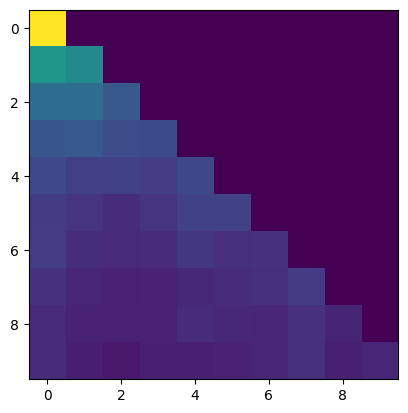

In [ ]:
# Visualize the alignment matrix for the first sample and first head
plt.imshow(attention_weights[0, 0].numpy())

# Positional Encoding

### Introducing Positional Encoding

The attention mechanism is permutation invariant. In order to account for the order of the embedding vectors $X^1, \dots, X^T \in \mathbb{R}^D$, we use positional encoding vectors.


The positional encoding vectors $p^1, \dots, p^T \in \mathbb{R}^D$ have the same dimension as the input embeddings $X^1, \dots, X^{T}$.




* For each time step $t \in \{1, \dots, T \}$, there is a unique positional encoding vector.
* The distance between two steps should be consistent across sentences with different lengths.



The method used in the original paper [vaswani2017attention](https://arxiv.org/pdf/1706.03762.pdf) is a linear transformation $T^{(k)} \in \mathbb{R}^{D \times D}$ such that

\begin{equation*}
    T^{(k)} p^{t} = p^{t+k}
\end{equation*}
  
It is defined as follows: For $d \in \{ 1, \dots, \frac{D}{2} \}$:

\begin{equation*}
    w_i = \frac{1}{100000^{\frac{2i}{D}}} \quad \text{and} \quad \quad  p^{t} = \begin{pmatrix}
    \sin(w_1 t) \\
    \cos(w_1 t) \\
    \vdots \\
    \sin(w_d t) \\
    \cos(w_d t) \\
    \vdots \\
    \sin(w_{\frac{D}{2}} t) \\
    \cos(w_{\frac{D}{2}} t) \\
    \end{pmatrix}
\end{equation*}




We define for a $d \in \{ 1, \dots, \frac{D}{2} \}$ and for all $t \in \{1 \dots, T\}$:

\begin{equation*}
    e_d^{t} =\begin{pmatrix}
    \sin{w_d t} \\
    \cos{w_d t}
    \end{pmatrix}
\end{equation*}

Therefore,


\begin{equation*}
    p^{t} = \begin{pmatrix}
    e_1^{t} \\
    \vdots \\
    e_d^{t} \\
    \vdots \\
    e_{\frac{D}{2}}^{t}
    \end{pmatrix}
\end{equation*}


By defining:
\begin{equation*}
    \mathcal{T}^{(k)} = \begin{pmatrix}
    \Phi_1^{(k)} &  &  &  &    \\
     & \ddots &  &  &    \\
     &  & \Phi_{d}^{(k)} &  &    \\
     &  & & \ddots &    \\
     &  & &  &  \Phi_{\frac{D}{2}}^{(k)}   \\
    \end{pmatrix} \quad \text{where} \quad  \Phi_d^{(k)} = \begin{pmatrix}
    \cos(w_d k) & \sin(w_d k) \\
    - \sin(w_d k) & \cos(w_d k)
    \end{pmatrix}
\end{equation*}


We get:

\begin{align*}
     \mathcal{T}^{(k)} p^{t} &= \begin{pmatrix}
    \Phi_1^{(k)} &  &  &  &    \\
     & \ddots &  &  &    \\
     &  & \Phi_{d}^{(k)} &  &    \\
     &  & & \ddots &    \\
     &  & &  &  \Phi_{\frac{D}{2}}^{(k)}   \\
    \end{pmatrix} \begin{pmatrix}
    e_1^{t} \\
    \vdots \\
    e_d^{t} \\
    \vdots \\
    e_{\frac{D}{2}}^{t}
    \end{pmatrix} \\
    &= \begin{pmatrix}
    \Phi_1^{(k)}  e_1^{t} \\
    \vdots \\
    \Phi_d^{(k)}  e_d^{t} \\
    \vdots \\
    \Phi_{\frac{D}{2}}^{(k)}  e_{\frac{D}{2}}^{t} \\
    \end{pmatrix}
\end{align*}


We have for all d in $\{ 1, \dots, \frac{D}{2} \}$:

\begin{align*}
    \Phi_d^{(k)}  e_d^{t} &= \begin{pmatrix}
    \cos(w_d k) & \sin(w_d k) \\
    - \sin(w_d k) & \cos(w_d k)
    \end{pmatrix}  \begin{pmatrix}
    \sin{w_d t} \\
    \cos{w_d t}
    \end{pmatrix} \\
    &= \begin{pmatrix}
    \cos(w_d k)  \sin{w_d t} +  \sin(w_d k)  \cos{w_d t} \\
     - \sin(w_d k) \sin{w_d t} + \cos(w_d k)  \cos{w_d t}
    \end{pmatrix} \\
    &= \begin{pmatrix}
    \sin \left( w_d (t + k) \right)  \\
    \cos \left( w_d (t + k) \right)  \\
    \end{pmatrix} \\
    &= e_d^{t+k}
\end{align*}


Therefore,

\begin{equation*}
     \mathcal{T}^{(k)} p^{t} = \begin{pmatrix}
    \Phi_1^{(k)}  e_1^{t} \\
    \vdots \\
    \Phi_d^{(k)}  e_d^{t} \\
    \vdots \\
    \Phi_{\frac{D}{2}}^{(k)}  e_{\frac{D}{2}}^{t} \\
    \end{pmatrix}
    =  \begin{pmatrix}
     e_1^{t+k} \\
    \vdots \\
     e_d^{t+k} \\
    \vdots \\
     e_{\frac{D}{2}}^{t+k} \\
    \end{pmatrix} = p^{t+k}
\end{equation*}


### Coding Positional Encoding

In [ ]:
def get_angles(positions, dimensions, D):
    """
    Get the angles of the positional embeddings

    Parameters
    ----------
    positions (T, 1) -- the positions for each
    dimensions (1, D) -- the dimensions
    D (int) -- Size of the embedding

    Returns
    -------
    (T, D) the angles of the positional embeddings

    """
    pass


In [ ]:
def positional_encoding(T, D):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        T (int) -- Maximum number of positions to be encoded
        D (int) -- Encoding size

    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles
    pass

### Visualizing positional encoding

(1, 200, 512)


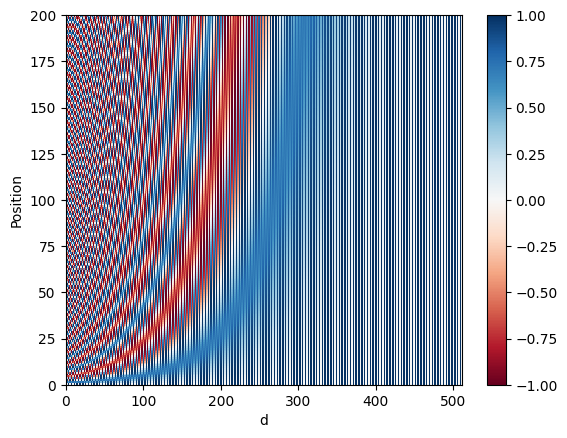

In [ ]:
pos_encoding = positional_encoding(200, 512)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# MultiHead Attention

### MultiHead Attention with the Scaled Dot Product Attention

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=13qvu8DouCrOjL4-Rn1-xRkaq6AoH7pB_"></center>

The scaled dot product attention can be generalized to any query $Q \in \mathbb{R}^{T_q \times d_q}$, key $K  \in \mathbb{R}^{T_k \times d_k} $ and value $V \in \mathbb{R}^{T_v \times d_v}$ matrices such that $d_q=d_k$ and $T_k = T_v = T'$.

\begin{equation*}
Q =    
\begin{bmatrix}
    \text{---} & q^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & q^{T_q} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T_q \times d_q}, \quad
K =    
\begin{bmatrix}
    \text{---} & k^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & k^{T_k} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T_k \times d_k}, \quad
V =    
\begin{bmatrix}
    \text{---} & v^{1} & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & v^{T_v} & \text{---} \\
\end{bmatrix} \in \mathbb{R}^{T_v \times d_v}
\end{equation*}

The scaled dot product attention matrix is then defined as follows:

\begin{equation*}
    A(Q, K, V) = \text{Softmax}\left(\frac{Q K^T}{\sqrt{d_k}} \right) V = \begin{bmatrix}
    \text{---} & A\left(q^1, (k^{t'})_{1 \leq t' \leq T'}, (v^{t'})_{1 \leq t' \leq T'}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^t, (k^{t'})_{1 \leq t' \leq T'}, (v^{t'})_{1 \leq t' \leq T'}\right) & \text{---} \\
    \vdots & \vdots & \vdots \\
    \text{---} & A\left(q^{T_q}, (k^{t'})_{1 \leq t' \leq T'}, (v^{t'})_{1 \leq t' \leq T'}\right) & \text{---} \\
    \end{bmatrix} \in \mathbb{R}^{T_q \times d_v}
\end{equation*}

The MultiHead Attention module, represented in figure \ref{fig:MHA}, consists in applying the attention mechanism defined in the previous section $h$ times in order to capture different notions of similarity.


Hence, for each head $h' \in \{1 \dots, h\}$, let $W_Q^{h'} \in \mathbb{R}^{d_q \times p_q}$, $W_K^{h'} \in \mathbb{R}^{d_k \times p_k}$ and $W_V^{h'} \in \mathbb{R}^{d_v \times p_v}$ be the $h'$-th projection matrices of $Q$, $K$ and $V$  onto the low dimensional key, query and value spaces of size $p_q$, $p_k$ and $p_v$, respectively. (We also have $p_q= p_k$).

The $h'$-th attention head is then defined as $A\left(Q W_Q^{h'}, K W_K^{h'}, V W_V^{h'} \right)$.


The concatenation layer aims at stacking all the attention heads together to make a new flatten vector, which is then projected onto $\mathbb{R}^{p_o}$ using the projection matrix $W_o \in \mathbb{R}^{h p_v \times p_o}$. The output of the MultiHead Attention layer $P$ is then computed as follows:


\begin{align*}
    P = \text{concat} \left( A\left(Q W_Q^{1}, K W_K^{1}, V W_V^{1} \right), \dots, A\left(Q W_Q^{h}, K W_K^{h}, V W_V^{h} \right) \right) W_o \in \mathbb{R}^{T_q \times p_o}
\end{align*}




### Coding MultiHead Attention Layer

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model



        if  self.d_model % self.num_heads != 0:
            raise Exception("The output dimension should be a multiple of the number of heads")

        self.d = self.d_model // self.num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.wo = Dense(d_model)

    def TransposeReshape(self, x):
        batch_size = x.shape[0]
        return tf.transpose(tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.d)), perm=[0,2,1,3])


    def call(self, q, k, v, mask=None):
        # Projection of q(N, T_Q, d_Q), k(N, T_K, d_K), v(N, T_V, d_V)
        q = self.wq(q) # (N, T_Q, d_model)
        k = self.wk(k) # (N, T_K, d_model)
        v = self.wv(v) # (N, T_V, d_model)

        # Reshape and Transpose q,k and v: (N, T_*, d_model) -> (N, h, T_*, d)
        q = self.TransposeReshape(q)
        k = self.TransposeReshape(k)
        v = self.TransposeReshape(v)

        # Apply Scaled Dot Producat Attention to q, k, v, mask -> scaled_attention, attention_weights
        # attention_output (N, h, T_Q, d)
        # attention_weights (N, h, T_Q, T_K)
        attention_output, attention_weights = scaled_dot_product_attention(q, k, v, mask=mask)

        # Transpose attention_output (N, h, T_Q, d) -> (N, T_Q, h, d)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])

        # Concat the last 2 dimensions (N, T_Q, h, d) -> (N, T_Q, d_model)
        attention_output = tf.reshape(attention_output, shape=(q.shape[0], -1, self.d_model))

        # Projection onto wo
        attention_output = self.wo(attention_output)

        # return attention_output (N, T_Q, d_model) and attention_weights (N, h, T_Q, T_K)
        return attention_output, attention_weights

### Test the MHA Layer

In [ ]:
# Hyperparameters
batch_size = 32
seq_len = 10
d_model = 64
num_heads = 8

# Create random data
q = tf.random.uniform((batch_size, seq_len, d_model))  # (32, 10, 64)
k = tf.random.uniform((batch_size, seq_len, d_model))  # (32, 10, 64)
v = tf.random.uniform((batch_size, seq_len, d_model))  # (32, 10, 64)

# Instantiate the MultiHeadAttention object
mha = MultiHeadAttention(num_heads, d_model)

# Call the object with the random data
output, attention_weights = mha(q, k, v, mask=create_look_ahead_mask(seq_len))

print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: (32, 10, 64)
Attention weights shape: (32, 8, 10, 10)


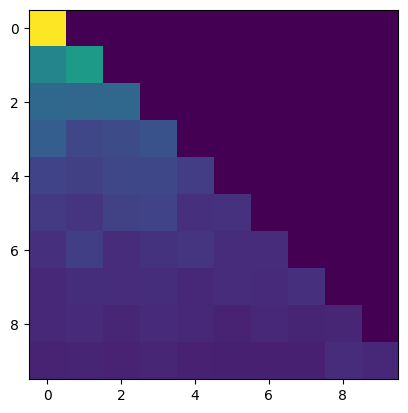

In [ ]:
# Visualize the alignment matrix for the first sample and first head
plt.imshow(attention_weights[0, 0].numpy())

# Contact

If you have any questions regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk

